### Jupyter Labの使い方Tips
#### **esc +**
esc + MでMarkdown，esc + Yでコード，esc + A/Bで現在のセルの上/下にセルを追加，esc + Xでセルをカット
#### **その他**
JupyterLabのメニュー「View」→「Show Line Numbers」にチェックを入れると、行番号が表示

Edit > Clear all outputで全てのセルの出力をクリア

<center>
    <h1 style="color:blue"><b>疎行列について</b></h1>
</center>
先ほどの<a href="Pressure1D_implicit.html">プログラム</a>で使用した係数行列$T$はその大部分が$0$になっており，このような行列を<b>疎行列</b>という。例えば$100$のグリッドを持つ場合，係数行列$T$のサイズは$100\times100$になるが，そのうち計算に真に必要なのは3重対角成分のみである。大部分が$0$であるにも関わらず，$N\times N$のフルサイズの行列を定義するのは効率が悪く，計算リソースを無駄に消費してしまう。そこで計算リソース節約のため，組み込み関数等を用いてフルサイズの行列ではなく，疎行列を定義することが推奨される。

<h2>詳細</h2>
$i$番目のグリッドと$i-1$番目のグリッド間の透過率，$i$番目のグリッドと$i+1$番目のグリッド間の透過率をそれぞれ

$$
T_w = \left.\frac{kA}{\mu\Delta x}\right|_{i-\frac{1}{2}}
$$
$$
T_e = \left.\frac{kA}{\mu\Delta x}\right|_{i+\frac{1}{2}}
$$

と定義することにして，さらに$T_o$を

$$
T_o = T_w + T_s
$$

と定めると，陰解法の離散化式は $B_i = \phi c V_i$ とおいて，

$$
-T_wP^{\left(n+1\right)}_{i-1} + \left(T_o + \frac{B_i}{\Delta t}\right)P^{\left(n+1\right)}_{i} -T_eP^{\left(n+1\right)}_{i+1}=
\frac{B_i}{\Delta t}P^{\left(n\right)}_i + Q
$$

両端が不透水境界であるとき，$T_w$ と $T_e$，$T_o$ は次のような配列になる。

<center>
<img src="fig/TwTeTo.png" width = "600px"></img>
</center>

ゆえに，係数行列$T$の要素を図示すると

<center>
<img src="fig/To_mat.png" width = "450px">
</center>

このような疎行列を生成するため，<code>Python</code>には次のような組み込み関数が用意されている。

<code>scipy.sparse.spdiags(data, diags, m=None, n=None, format=None)</code>

引数はそれぞれ<br>
<ul>
    <li><code>data</code>：対角成分の要素</li>
    <li><code>diags</code>：<code>data</code>で指定された配列をどこに配置するか。
    <code>k=0</code>なら対角部分，
    <code>k>0</code>なら上三角行列に対応する部分（中心から離れるほど
    <code>k</code>の値が大きくなる。），
    <code>k<0</code>なら下三角成分に対応する部分
        </li>
<li><code>m</code>：行列の行数</li>
<li><code>n</code>：行列の列数</li>
</ul>

<h3>具体例</h3>
いま，
<code>
    Tw = [0, 1, 2, 3,..., 9]
</code>
<code>
    Te = [9, 8, 7, 6, ..., 0]
</code>
<code>
    To = Tw + Te = [9, 9, ..., 9]
    </code>

であったとすると，生成したい疎行列は
<center>
<img src="fig/T_example.png" width = "450px">
</center>

このような行列$T$を生成するpythonのコードを以下に示す。

In [55]:
import numpy as np
from scipy.sparse import spdiags

Tw = np.linspace(0, 9, 10)
Te = np.linspace(9, 0, 10)

To = Tw + Te

T = spdiags([Te, To, Tw], [-1, 0, 1], 10, 10)
T = T.T

In [56]:
print(T.toarray())

[[9. 9. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 9. 8. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 9. 7. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 9. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 9. 5. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 9. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 6. 9. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 7. 9. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 9. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 9. 9.]]


9行目と10行目に注意してほしい。<code>.T</code>は転置を表す。Pythonの挙動と圧力拡散方程式獲得に必要な要素の配置を下に示した。

<center>
    <img src="fig/matcomp.png"  width = "700px">
    </center>

（拡散方程式の係数行列に必要なのは，<code>Te，To，Tw</code>を横に並べたものだが，Python spdiagsは縦に並べるイメージ？）

In [48]:
spdiags([Tw, To, Te], [-1, 0, 1], 10, 10).toarray()

array([[9., 8., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 9., 7., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 9., 6., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 9., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 9., 4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 9., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 9., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 6., 9., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 7., 9., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 8., 9.]])

<h3>メモリの節約量</h3>
<code>spdiags</code>による疎行列生成がどの程度メモリの節約になるのか示す。

In [128]:
N = 5
# 通常の行列
A = np.zeros([N, N])
for i in range(0, N):
    if i == 0:
        A[i,i]   = 2
        A[i,i+1] = 1
    elif i == N-1:
        A[i,i]   = 2
        A[i,i-1] = -1
    else:
        A[i,i]   = 2
        A[i,i+1] = 1
        A[i,i-1] = -1
        
# 疎行列（疎配列？）
a = np.ones(N);
b = -1*np.ones(N);
c = 2*np.ones(N);

B = spdiags([a, c, b], [1, 0, -1], N,N)

In [129]:
print(A)

[[ 2.  1.  0.  0.  0.]
 [-1.  2.  1.  0.  0.]
 [ 0. -1.  2.  1.  0.]
 [ 0.  0. -1.  2.  1.]
 [ 0.  0.  0. -1.  2.]]


In [130]:
print(B.toarray())

[[ 2.  1.  0.  0.  0.]
 [-1.  2.  1.  0.  0.]
 [ 0. -1.  2.  1.  0.]
 [ 0.  0. -1.  2.  1.]
 [ 0.  0.  0. -1.  2.]]


In [131]:
print("疎行列でない場合のメモリ消費数：{}".format(A.__sizeof__()))
print("疎行列のメモリ消費数：{}".format(B.__sizeof__()))

疎行列でない場合のメモリ消費数：320
疎行列のメモリ消費数：32


<h2>拡散方程式への実装</h2>
以上の<b>疎行列</b>を使って圧力拡散方程式のコードを書き直すと次の通りになる。

In [1]:
## Import Modules & Plot function
import numpy as np
from scipy.stats import hmean
from scipy.sparse import spdiags
import matplotlib.pyplot as plt

def SavePlot(x, P, t, L):
  # Function to Plot & Save Pressure
  # fig = plt.figure()
    plt.plot(x, P_new, label='t={0:05.2f}'.format(t)) 
    plt.xlabel('x[m]')
    plt.ylabel('Pressure [Pa]')
    plt.xlim(0, L)
    #plt.ylim(-1, 1)
    plt.grid()
    plt.title('Aquifer Pressure@{0:05.2f}[s]'.format(t))
  # fig.savefig('t={0:05.2f}.png'.format(t)) #画像保存には20行目と21行目も実行
  # plt.clf()
    return
    
def SaveCountourOf1Ddata(P, t, L, W, Pmin, Pmax,n, saveflag):
    plt.imshow([P_new, P_new], extent = [0, L, 0, W], cmap = 'jet', vmin=Pmin, vmax=Pmax)
    plt.xlabel('L[m]')
    plt.ylabel('W[m]')
    plt.title("Aquifer Pressure [Pa]@ {:08.2f}days".format(t/86400))
    plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)
    if saveflag:
        fig.savefig('result/SP_AP{:08.2f}days.png'.format(t/86400), facecolor="white") #画像保存には20行目と21行目も実行%filename に＠や[]はつけない
    plt.clf()
    return

In [21]:
## Input Parmeters
# time step & boundary condition controll
dt   = 43200*14*4   # dt [s] 43200[s] is equal to 0.5 days
#tmax = 43200*2*365.25*10 # Time to stop simlation [s]
tmax = dt * 12 * 1500
nout = 1000  # output result ever nout step[]
saveflag = False # flag to save contour map
# Variable to decide Boundary condition
#  1> Neumann, 0> Dirichlet
BC_east = 1 # Boundary at right(x = L) 
BC_west  = 1 # Boundary at Left (x = 0)
Pb_east = 1e6 # Pressure Value at x = L
Pb_west  = 1e6 # Pressure Value at x = 0

# Aquifer Geometory & coordinate
L   = 3000     # Length of theReservoir [m]
W   = 100          # Width of the Reservoir [m]
h   = 10         # Tickness of the Reservoir [m]
N   = 51         # Number of Control Volume [-]
dx  = L/N         # Length of Control Volume[m]
A   = W*h           # cross-sectional area of reservoir [m^2]
x   = np.zeros(N) # x coordinate[m]
# Coordinate points of CV-center
x[0]= dx/2
for i in range(1, N):
    x[i] = x[i-1] + dx
    
# Aquifer Properties
perm   = 1e-4*np.ones(N)    # Absolute Permiability Field [m^2]
phi    = 0.3*np.ones(N)  # Porosity Field [-]
#P_init = np.abs(np.sin(x))     # Initial Condition of Pressure [Pa]
P_init = 1e6*np.ones(N)

# Fluid Properties
c    = 1     # Compressibility[Pa^-1]
mu   = 1     # Viscosity of Fluid[Pa*s]

# Well Parameters
Q   = np.zeros(N) # Source vector[m^/s]
# Q[3] = 0.05 # > 0, Injection wells
# Q[5] = -0.05 # < 0, Pumping wells
Q[int((N-1)/2)] = -0.05 # < 0, Pumping wells

In [22]:
## definition of Matrix for Linear simultaneous Eq.
T_west = np.zeros(N)
T_east = np.zeros(N)
To = np.zeros(N)
B  = np.zeros([N,N]) # Volume accumulation Matrix

#T
for i in range(0, N):
    if i == 0:
        Tw = A/(mu*dx)*(2*( perm[i] * perm[i] )/( perm[i] + perm[i]) )
        Te = A/(mu*dx)*(2*( perm[i] * perm[i+1] )/( perm[i] + perm[i+1]) )
        if BC_west == 0:
            To[i] = Tw + Te
            Q[0] = 2*Tw*Pb_east

        else:
            To[i] = Te
        T_west[i] = 0
        T_east[i] = Te
            
    elif i == N-1:
        Tw = A/(mu*dx)*(2*( perm[i-1] * perm[i] )/( perm[i-1] + perm[i]) )
        Te = A/(mu*dx)*(2*( perm[i] * perm[i] )/( perm[i] + perm[i]) )
        if BC_east == 0:
            To[i] = Tw + Te
            Q[N-1] = 2*Te*Pb_west
        else:
            To[i] = Te
        T_west[i] = Tw
        T_east[i] = 0
    else:
        Tw = A/(mu*dx)*(2*( perm[i-1] * perm[i] )/( perm[i-1] + perm[i]) )
        Te = A/(mu*dx)*(2*( perm[i] * perm[i+1] )/( perm[i] + perm[i+1]) )
        To[i] = Tw + Te
        T_west[i] = Tw
        T_east[i] = Te

#spdiags T
T = spdiags([-T_east, To, -T_west], [-1, 0, 1], N, N).T

# B
for i in range(0, N):
    B[i,i] = A*dx*phi[i]*c


1000th Time step , day28000.00
2000th Time step , day56000.00
3000th Time step , day84000.00
4000th Time step , day112000.00
5000th Time step , day140000.00
6000th Time step , day168000.00
7000th Time step , day196000.00
8000th Time step , day224000.00
9000th Time step , day252000.00
10000th Time step , day280000.00
11000th Time step , day308000.00
12000th Time step , day336000.00
13000th Time step , day364000.00
14000th Time step , day392000.00
15000th Time step , day420000.00
16000th Time step , day448000.00
17000th Time step , day476000.00


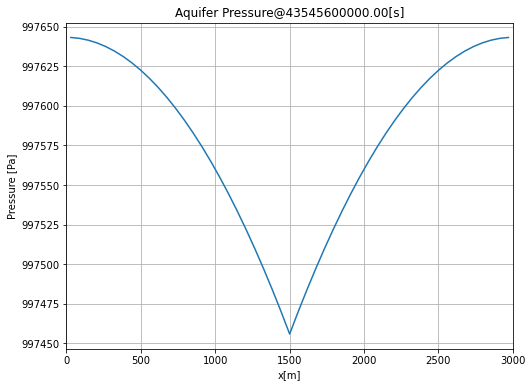

In [23]:
## Simulation
P_old  = np.copy(P_init) # Pressure at n-th step
P_new  = np.copy(P_init) # Pressure at n+1-th step
t = 0
n = 0
fig = plt.figure(figsize=(8.0, 6.0))
Pmax = np.max([np.max(P_init), Pb_east, Pb_west])
Pmin = np.min([np.min(P_init), Pb_east, Pb_west])

# Plot Initial Condition
#SavePlot(x, P_new, t, L)
SaveCountourOf1Ddata(P_init, t, L, W, Pmin, Pmax, n, saveflag)
while True:
    # solve Simultaneous equations
    P_new = np.linalg.solve((T + B/dt), (np.dot(B/dt,P_old)+Q)) 
    
    # Update Values, time step and Add plot
    P_old = np.copy(P_new)
    t = t + dt
    n = n + 1
    
    if t >= tmax:
        break
    
    if n%nout == 0:
        print('{0}th Time step , day{1:05.2f}'.format(n, t/(86400)))
 #       SavePlot(x, P_new, t, L)
        SaveCountourOf1Ddata(P_new, t, L, W, Pmin, Pmax, n, saveflag)

            
SavePlot(x, P_new, t, L)
# plt.legend()
plt.show()

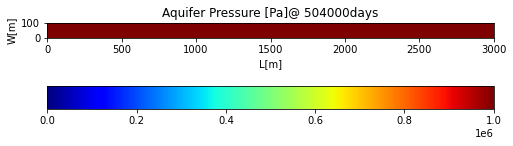

In [24]:
fig = plt.figure(figsize=(8.0, 6.0))
plt.imshow([P_new, P_new], extent = [0, L, 0, W], cmap = 'jet', vmin=0, vmax=1e6)
plt.xlabel('L[m]')
plt.ylabel('W[m]')
plt.title("Aquifer Pressure [Pa]@ {:d}days".format(int(t/86400)))
plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)

<h2>結果のgif</h2>
<img src="APressureUsingSP.gif">

<center>
    <a href="../../index.html">戻る</a>
</center>